## Backtesting with Real-World Adjustments

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# Set Seaborn style
sns.set_theme(style="whitegrid", rc={"axes.facecolor": "#f0f0f0"})

###  Load Model and Data

In [2]:
# Load model and engineered data
best_model = joblib.load("QQQ_XGBoost_Model.pkl")
df = pd.read_csv("QQQ_Engineered_Data.csv", parse_dates=["Date"], index_col="Date")

# Recreate target variable
df["Target"] = (df["Close"].shift(-1) > df["Close"]).astype(int)
df.dropna(subset=["Target"], inplace=True)

### Generate Predictions for Test Data

In [3]:
# Split features/target (same as Day 3)
X = df.drop("Target", axis=1)  # Keep "Close" in X for backtesting
y = df["Target"]
split_idx = int(0.8 * len(X))
X_test = X.iloc[split_idx:]
y_test = y.iloc[split_idx:]

# Predict signals (now includes "Close" in test_df)
test_df = X_test.copy()
test_df["Predicted_Signal"] = best_model.predict(X_test.drop("Close", axis=1))  # Exclude "Close" from prediction
test_df["Actual_Return"] = df["Close"].pct_change().shift(-1).iloc[split_idx:]
test_df.dropna(inplace=True)

### Enhanced Backtesting Function

In [4]:
def backtest_qqq(data, initial_capital=1000, transaction_cost=0.0005, stop_loss_pct=0.03):
    capital = initial_capital
    position = 0  # 0 = out, 1 = long
    shares = 0
    portfolio = []
    trades = []
    
    for i in range(len(data)):
        current_price = data["Close"].iloc[i]
        signal = data["Predicted_Signal"].iloc[i]
        
        # Buy signal
        if signal == 1 and position == 0:
            shares = (capital * (1 - transaction_cost)) / current_price
            capital = 0
            position = 1
            entry_price = current_price
            trades.append(("Buy", data.index[i], entry_price))
        
        # Sell signal or stop-loss
        if position == 1:
            current_return = (current_price - entry_price) / entry_price
            if signal == 0 or current_return <= -stop_loss_pct:
                capital = shares * current_price * (1 - transaction_cost)
                shares = 0
                position = 0
                trades.append(("Sell", data.index[i], current_price))
        
        # Track portfolio value
        portfolio.append(shares * current_price + capital)
    
    results = pd.DataFrame({
        "Date": data.index,
        "Portfolio_Value": portfolio
    })
    return results, trades

### Run Backtest

In [5]:
# Run backtest with enhanced logic
backtest_results, trades = backtest_qqq(test_df)

# Calculate metrics
initial_capital = 1000
final_value = backtest_results["Portfolio_Value"].iloc[-1]
total_return_pct = (final_value / initial_capital - 1) * 100

# Trade performance
trade_returns = []
for i in range(0, len(trades)-1, 2):
    entry_price = trades[i][2]
    exit_price = trades[i+1][2]
    trade_returns.append((exit_price - entry_price) / entry_price)

win_rate = np.mean(np.array(trade_returns) > 0) * 100 if trade_returns else 0.0

print(f"Total Return: {total_return_pct:.2f}%")
print(f"Number of Trades: {len(trades)//2}")
print(f"Win Rate: {win_rate:.2f}%")

Total Return: 29.62%
Number of Trades: 35
Win Rate: 45.71%


### Visualize Results

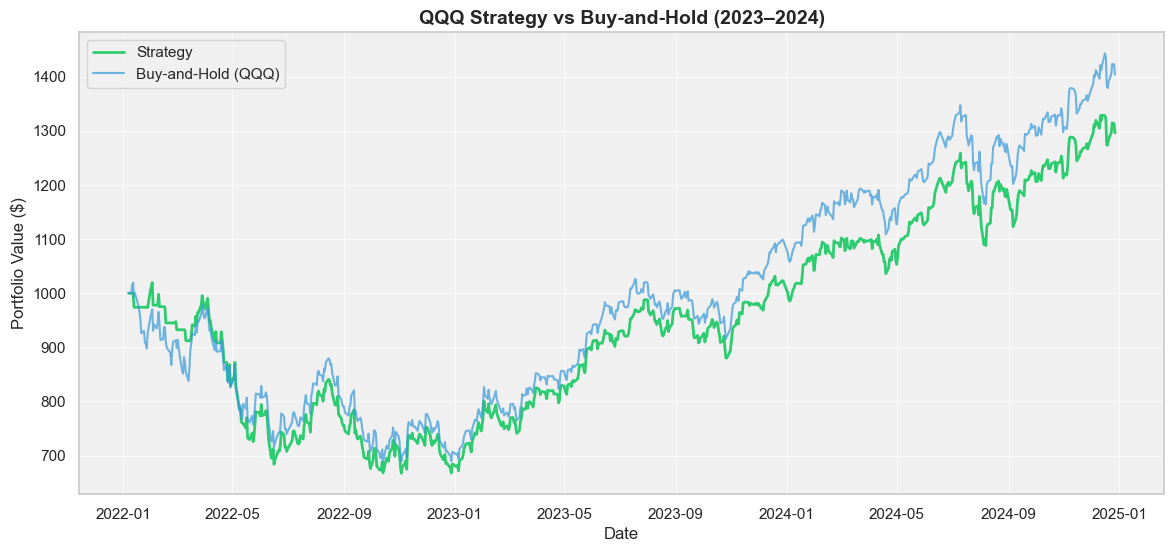

In [6]:
plt.figure(figsize=(14, 6))
plt.plot(backtest_results["Date"], backtest_results["Portfolio_Value"], 
         color="#2ecc71", linewidth=2, label="Strategy")
plt.plot(test_df["Close"] / test_df["Close"].iloc[0] * initial_capital, 
         color="#3498db", alpha=0.7, label="Buy-and-Hold (QQQ)")
plt.title("QQQ Strategy vs Buy-and-Hold (2023–2024)", fontsize=14, fontweight="bold")
plt.xlabel("Date")
plt.ylabel("Portfolio Value ($)")
plt.legend()
plt.grid(True, color="white", linestyle="-", linewidth=0.5)
plt.gca().set_facecolor("#f0f0f0")
plt.show()

###  Save Results

In [7]:
backtest_results.to_csv("QQQ_Backtest_Results.csv", index=False)
print("Backtest results saved to 'QQQ_Backtest_Results.csv'")

Backtest results saved to 'QQQ_Backtest_Results.csv'
